### **Task 1: Data Exploration**

- Load the dataset and examine its structure
- Check for missing values and outliers
- Create a correlation heatmap between features
- Generate scatter plots for key feature relationships

### **Task 2: Data Preprocessing**

- Handle missing values (if any)
- Split data into training (80%) and testing (20%) sets
- Apply feature scaling using StandardScaler
- Create polynomial features for at least one variable

### **Task 3: Model Implementation**

- Implement linear regression using scikit-learn
- Train the model on training data
- Make predictions on the test set
- Compare with a Ridge regression model (alpha=1.0)

### **Task 4: Analysis & Insights**

- Identify the most important features
- Discuss model limitations
- Suggest improvements for better performance

In [37]:
# Cell: Imports and load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set(style="whitegrid", context="notebook")

# Load the dataset (absolute path to avoid path issues)
csv_path = "housing.csv"
df = pd.read_csv(csv_path)

print("Shape:", df.shape)
display(df.head())
display(df.describe(include="all"))
print("\nMissing values per column:\n", df.isna().sum())

Shape: (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1H OCEAN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9136
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,NaN
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,NaN
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,NaN
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,NaN
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,NaN
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,NaN



Missing values per column:
 longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


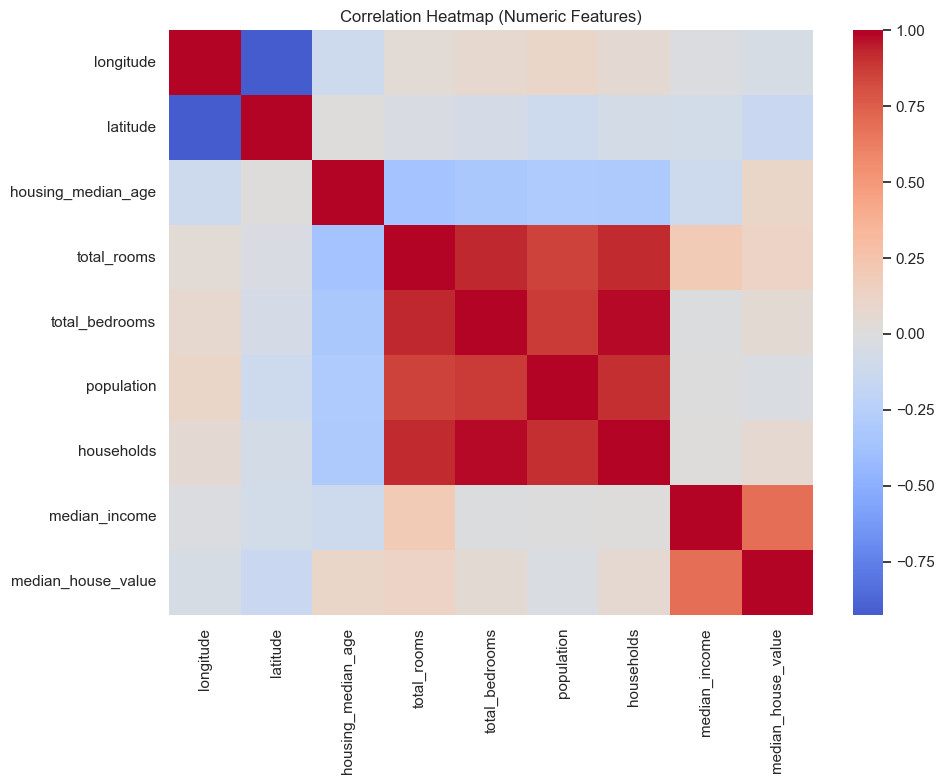

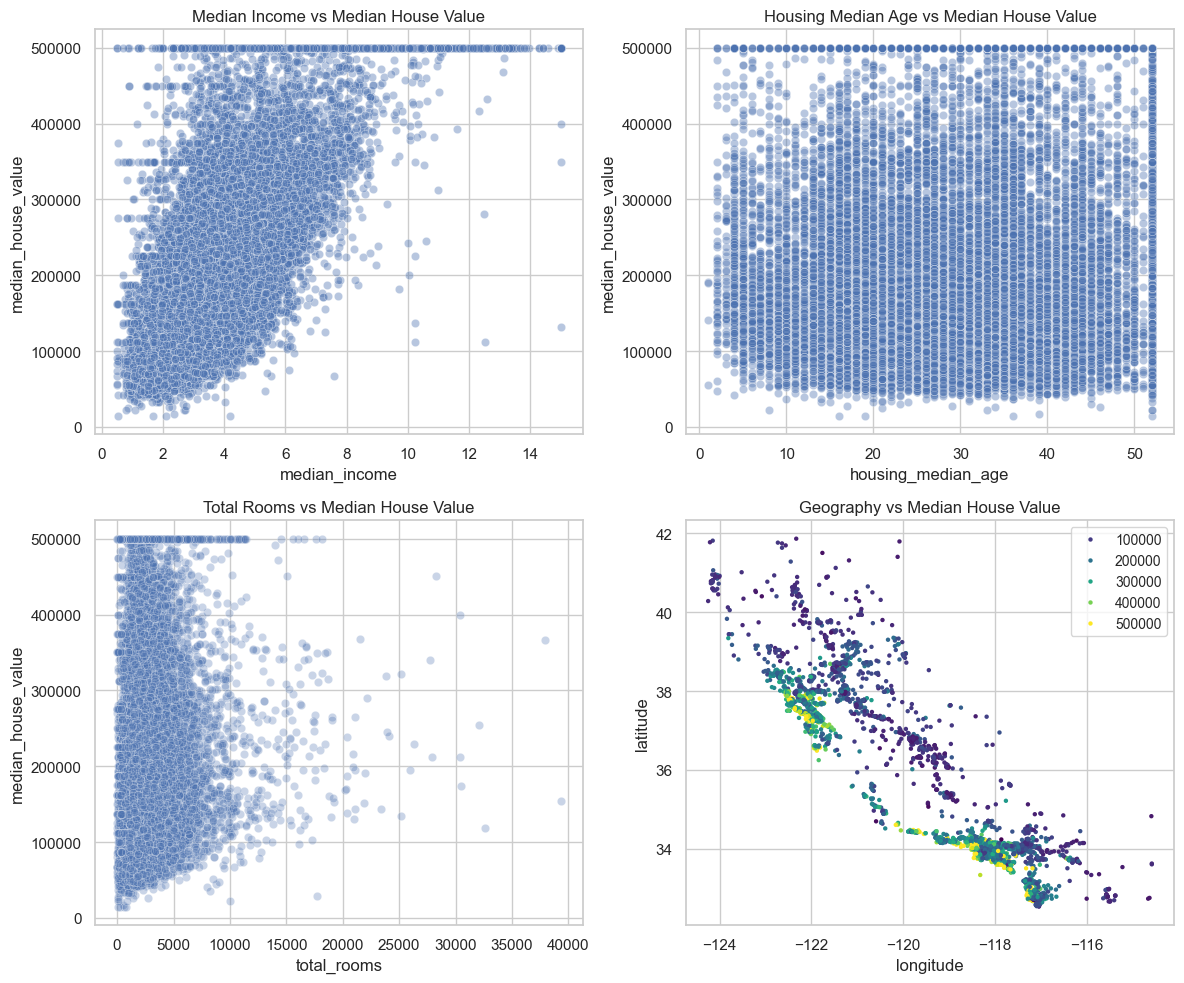

In [38]:
# Cell: Data exploration visuals
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(10,8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.scatterplot(ax=axes[0,0], data=df, x="median_income", y="median_house_value", alpha=0.4)
axes[0,0].set_title("Median Income vs Median House Value")

sns.scatterplot(ax=axes[0,1], data=df, x="housing_median_age", y="median_house_value", alpha=0.4)
axes[0,1].set_title("Housing Median Age vs Median House Value")

sns.scatterplot(ax=axes[1,0], data=df, x="total_rooms", y="median_house_value", alpha=0.3)
axes[1,0].set_title("Total Rooms vs Median House Value")

# Geo scatter: lat/long colored by price
sns.scatterplot(
    ax=axes[1,1], data=df.sample(min(5000, len(df)), random_state=42),
    x="longitude", y="latitude", hue="median_house_value", palette="viridis", s=10, linewidth=0
)
axes[1,1].set_title("Geography vs Median House Value")
axes[1,1].legend(loc="best", fontsize="small")
plt.tight_layout()
plt.show()

In [39]:
# Cell: Preprocessing setup (imputation, scaling, polynomial feature on median_income)
target_col = "median_house_value"
X = df.drop(columns=[target_col])
y = df[target_col].values

cat_features = [c for c in X.columns if X[c].dtype == "object"]
num_features = [c for c in X.columns if c not in cat_features]

# We'll create polynomial features for 'median_income'
poly_base = "median_income"
num_no_poly = [c for c in num_features if c != poly_base]

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

income_poly_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, num_no_poly),
    ("income_poly", income_poly_pipeline, [poly_base]),
    ("cat", categorical_pipeline, cat_features)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Categorical:", cat_features)
print("Numeric (no poly):", num_no_poly)
print("Poly on:", [poly_base])

Train shape: (16512, 9)  Test shape: (4128, 9)
Categorical: ['ocean_proximity']
Numeric (no poly): ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households']
Poly on: ['median_income']


In [40]:
# Cell: Models (Linear Regression and Ridge)
lin_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("reg", LinearRegression())
])

ridge_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("reg", Ridge(alpha=1.0))
])

lin_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)

lin_pred = lin_model.predict(X_test)
ridge_pred = ridge_model.predict(X_test)

def eval_reg(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | R2: {r2:.4f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

lin_metrics = eval_reg(y_test, lin_pred, "Linear Regression")
ridge_metrics = eval_reg(y_test, ridge_pred, "Ridge (alpha=1.0)")

Linear Regression -> MAE: 50,925.98 | RMSE: 4,915,374,738.78 | R2: 0.6249
Ridge (alpha=1.0) -> MAE: 50,930.59 | RMSE: 4,916,032,539.70 | R2: 0.6248


In [41]:
# Cell: Feature importance (top weighted features by absolute coefficient)
# Extract feature names from the ColumnTransformer
pre = lin_model.named_steps["preprocess"]
feature_names = []
# numeric (no poly)
feature_names += pre.named_transformers_["num"].get_feature_names_out(num_no_poly).tolist()
# income poly
# PolynomialFeatures expands 'median_income' into terms like 'median_income', 'median_income^2'
income_names = pre.named_transformers_["income_poly"].named_steps["poly"].get_feature_names_out([poly_base]).tolist()
feature_names += income_names
# categorical one-hot
if cat_features:
    cat_names = pre.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(cat_features).tolist()
    feature_names += cat_names

# Linear regression coefficients
lin_coefs = lin_model.named_steps["reg"].coef_.ravel()
ridge_coefs = ridge_model.named_steps["reg"].coef_.ravel()

lin_importance = pd.Series(np.abs(lin_coefs), index=feature_names).sort_values(ascending=False)
ridge_importance = pd.Series(np.abs(ridge_coefs), index=feature_names).sort_values(ascending=False)

print("Top 10 features (Linear Regression):")
display(lin_importance.head(10).to_frame("abs_coef"))
print("Top 10 features (Ridge):")
display(ridge_importance.head(10).to_frame("abs_coef"))

Top 10 features (Linear Regression):


,abs_coef
ocean_proximity_ISLAND,117837.599002
median_income,93408.502639
ocean_proximity_INLAND,58193.965901
latitude,52284.761869
longitude,51878.451770
total_bedrooms,48899.638302
population,41800.971434
ocean_proximity_NEAR BAY,24743.438926
ocean_proximity_<1H OCEAN,19736.092041
total_rooms,18108.532452


Top 10 features (Ridge):


,abs_coef
ocean_proximity_ISLAND,98195.603273
median_income,93319.268439
ocean_proximity_INLAND,53310.134821
latitude,52256.370985
longitude,51840.814998
total_bedrooms,48821.581179
population,41801.942444
ocean_proximity_NEAR BAY,19807.845256
total_rooms,18041.216150
median_income^2,17720.221274


In [42]:
# Cell: Brief discussion/insights (printed)
print("Insights and notes:")
print("- Median income is typically the strongest predictor; the polynomial term often helps capture nonlinearity.")
print("- Geographic coordinates (longitude/latitude) and proximity categories contribute due to spatial price patterns.")
print("- Total rooms/bedrooms without normalization by households can be less informative; engineered ratios like rooms_per_household, bedrooms_per_room often help.")
print("- Limitations: target is capped at 500k in this dataset; linear models assume linear relationships and are sensitive to outliers.")
print("- Improvements: add feature engineering (rooms_per_household, bedrooms_per_room, population_per_household), try ElasticNet/XGBoost, and tune Ridge alpha via CV.")

Insights and notes:
- Median income is typically the strongest predictor; the polynomial term often helps capture nonlinearity.
- Geographic coordinates (longitude/latitude) and proximity categories contribute due to spatial price patterns.
- Total rooms/bedrooms without normalization by households can be less informative; engineered ratios like rooms_per_household, bedrooms_per_room often help.
- Limitations: target is capped at 500k in this dataset; linear models assume linear relationships and are sensitive to outliers.
- Improvements: add feature engineering (rooms_per_household, bedrooms_per_room, population_per_household), try ElasticNet/XGBoost, and tune Ridge alpha via CV.
